In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from netcal.metrics import ECE, ACE

from utils_notebook import get_logits_targets, get_probs_ovr_poe_w_adapt_thres_log_reg, modal_probs_decreasing, grid_search_adapt_thres

from collections import OrderedDict, Counter
import random
from typing import Dict

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

/home/metod/miniconda3/envs/msdnet/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
MODEL_FOLDER = 'models_use_valid'
LIKELIHOOD = 'softmax'
EPOCH = 299

In [3]:
logits_val, targets_val, ARGS = get_logits_targets('cifar100', MODEL_FOLDER, LIKELIHOOD, EPOCH, cuda=False, logits_type='val')
logits_test, targets_test, ARGS = get_logits_targets('cifar100', MODEL_FOLDER, LIKELIHOOD, EPOCH, cuda=False, logits_type='test')
logits_train, targets_train, ARGS = get_logits_targets('cifar100', MODEL_FOLDER, LIKELIHOOD, EPOCH, cuda=False, logits_type='train')

building network of steps: 
[4, 2, 2, 2, 2, 2, 2] 16
 ********************** Block 1  **********************
|		inScales 3 outScales 3 inChannels 16 outChannels 6		|

|		inScales 3 outScales 3 inChannels 22 outChannels 6		|

|		inScales 3 outScales 3 inChannels 28 outChannels 6		|

|		inScales 3 outScales 3 inChannels 34 outChannels 6		|

 ********************** Block 2  **********************
|		inScales 3 outScales 3 inChannels 40 outChannels 6		|

|		inScales 3 outScales 3 inChannels 46 outChannels 6		|

 ********************** Block 3  **********************
|		inScales 3 outScales 2 inChannels 52 outChannels 6		|
|		Transition layer inserted! (max), inChannels 58, outChannels 29	|

|		inScales 2 outScales 2 inChannels 29 outChannels 6		|

 ********************** Block 4  **********************
|		inScales 2 outScales 2 inChannels 35 outChannels 6		|

|		inScales 2 outScales 2 inChannels 41 outChannels 6		|

 ********************** Block 5  **********************
|		inScales 2 outS

/home/metod/miniconda3/envs/msdnet/lib/python3.8/site-packages/torch/cuda/__init__.py:88: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


building network of steps: 
[4, 2, 2, 2, 2, 2, 2] 16
 ********************** Block 1  **********************
|		inScales 3 outScales 3 inChannels 16 outChannels 6		|

|		inScales 3 outScales 3 inChannels 22 outChannels 6		|

|		inScales 3 outScales 3 inChannels 28 outChannels 6		|

|		inScales 3 outScales 3 inChannels 34 outChannels 6		|

 ********************** Block 2  **********************
|		inScales 3 outScales 3 inChannels 40 outChannels 6		|

|		inScales 3 outScales 3 inChannels 46 outChannels 6		|

 ********************** Block 3  **********************
|		inScales 3 outScales 2 inChannels 52 outChannels 6		|
|		Transition layer inserted! (max), inChannels 58, outChannels 29	|

|		inScales 2 outScales 2 inChannels 29 outChannels 6		|

 ********************** Block 4  **********************
|		inScales 2 outScales 2 inChannels 35 outChannels 6		|

|		inScales 2 outScales 2 inChannels 41 outChannels 6		|

 ********************** Block 5  **********************
|		inScales 2 outS

In [4]:
targets_train.shape, targets_val.shape, targets_test.shape

(torch.Size([45000]), torch.Size([5000]), torch.Size([10000]))

In [5]:
# TODO: fit a model only on train data, then predict on val and test data
(logits_test[0].argmax(axis=1) == targets_test).sum() / len(targets_test), (logits_val[0].argmax(axis=1) == targets_val).sum() / len(targets_val), (logits_train[0].argmax(axis=1) == targets_train).sum() / len(targets_train)

(tensor(0.6128), tensor(0.5984), tensor(0.9024))

In [6]:
val_labels = (logits_val[0].argmax(axis=1) == targets_val).numpy().astype(int)

In [7]:
# top two logits using torch topk
top2_logits, top2_labels = torch.topk(torch.tensor(logits_val[0]), 2, dim=1)

# PCA embedding sof logits
pca = PCA(n_components=2)
logits_pca = pca.fit_transform(logits_val[0])

/tmp/ipykernel_104486/3421320213.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  top2_logits, top2_labels = torch.topk(torch.tensor(logits_val[0]), 2, dim=1)


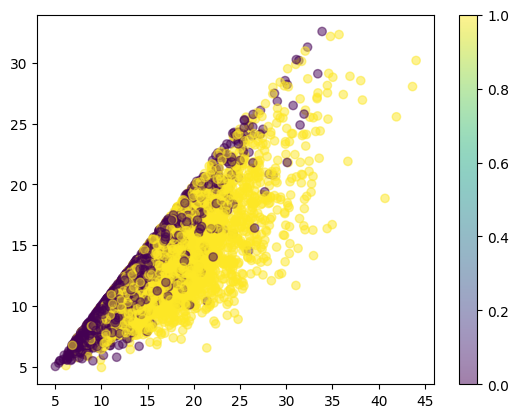

In [8]:
# plot scatter plot of top two logits and color w.r.t. val_labels
plt.scatter(top2_logits[:, 0], top2_logits[:, 1], c=val_labels, alpha=0.5)
plt.colorbar()
plt.show()

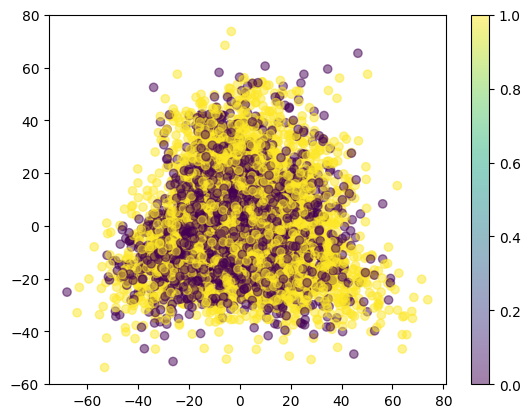

In [9]:
# plot scatter plot of PCA embeddings and color w.r.t. val_labels
plt.scatter(logits_pca[:, 0], logits_pca[:, 1], c=val_labels, alpha=0.5)
# add color legend to the plot
plt.colorbar()
plt.show()

In [10]:
X = top2_logits.numpy()
y = val_labels

clf = LogisticRegression(random_state=0).fit(X, y)

In [13]:
N, L = len(logits_val[0]), len(logits_val)

In [14]:
N, L 

(5000, 7)

In [11]:
C_dict_val = grid_search_adapt_thres(logits_val, targets_val, clf)
C_dict_test = grid_search_adapt_thres(logits_test, targets_test, clf)

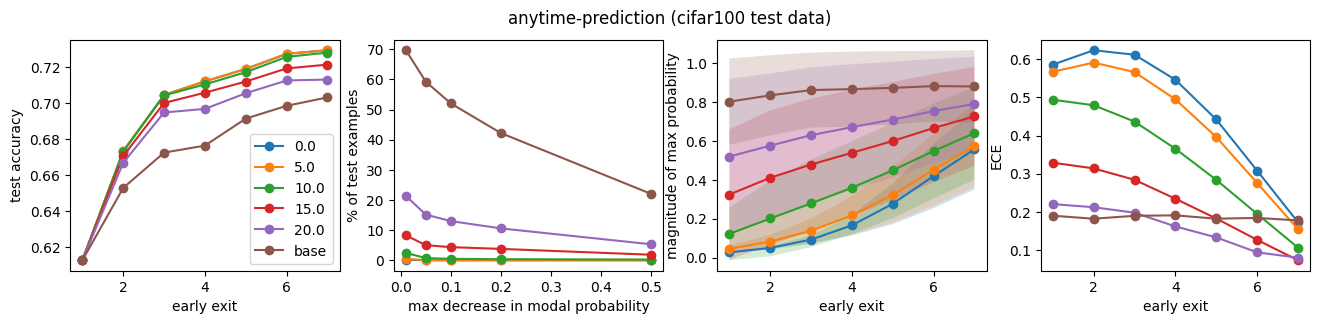

In [15]:
# _targets = targets_val
# _dict = C_dict_val
# _label = 'validation'

_targets = targets_test
_dict = C_dict_test
_label = 'test'

early_exits = [i + 1 for i in range(L)]
fig, ax = plt.subplots(1, 4, figsize=(16, 3))
for label, arrs in _dict.items():
    _probs, _preds, _acc = arrs
    ax[0].plot(early_exits, _acc, label=label, marker='o',)

    
    modal_probs = modal_probs_decreasing(_preds, _probs, layer=L, N=N)
    ax[1].plot(modal_probs.keys(), modal_probs.values(), marker='o', label=label)

    mean_magnitude, std_magnitude = _probs.max(2).values.mean(1), _probs.max(2).values.std(1)

    ax[2].plot(early_exits, mean_magnitude, marker='o', label=label)
    ax[2].fill_between(early_exits, mean_magnitude - std_magnitude, mean_magnitude + std_magnitude, alpha=0.2)

    ece = []
    for l in range(L):
        ece.append(ECE(bins=15).measure(_probs[l, :, :].numpy(), _targets.numpy()))
    ax[3].plot(early_exits, ece, marker='o', label=label)

ax[1].set_xlabel('max decrease in modal probability')
ax[1].set_ylabel('% of test examples')

ax[2].set_xlabel('early exit')
ax[2].set_ylabel('magnitude of max probability')

ax[3].set_xlabel('early exit')
ax[3].set_ylabel('ECE')

ax[0].legend()
# ax[0].set_title('anytime-prediction')
ax[0].set_ylabel('test accuracy')
ax[0].set_xlabel('early exit')

plt.suptitle(f'anytime-prediction ({ARGS.data} {_label} data)')
plt.show()